За разделянето на данните използвам :

import splitfolders

splitfolders.ratio("Input", output="Output",seed=1337, ratio=(.75, .25), group_prefix=None, move=True)

като предварително трябва да са разделени сниките в папка с името на съответните им класове , в нашия случай Cats и  Dogs

In [85]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch


In [86]:
train = "Output/train"
test = "Output/test"

img_size = (200, 200)
batch_size = 32
img_tf = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
     transforms.Normalize(0.485, 0.229)
    ])


train_data = torchvision.datasets.ImageFolder(root = train, transform = img_tf)
test_data = torchvision.datasets.ImageFolder(root = test, transform = img_tf)


train_dl = DataLoader(train_data, batch_size = batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size = batch_size, shuffle=True)

In [87]:
print(f'Num training images: {len(train_dl.dataset)}')
print(f'Num test images: {len(test_dl.dataset)}')

Num training images: 18748
Num test images: 6250


In [88]:
x, y = next(iter(train_dl))
print(x.shape, y.shape)

torch.Size([32, 3, 200, 200]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


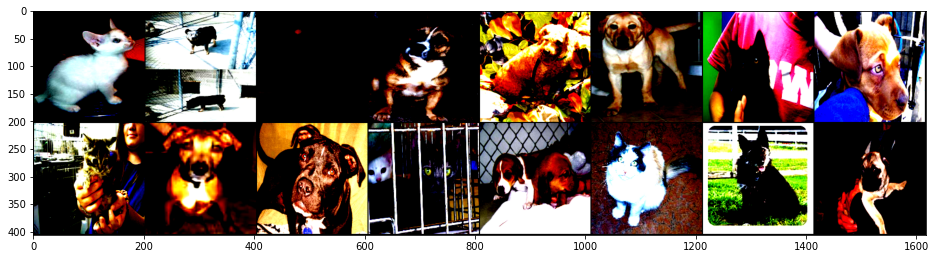

In [89]:
images, labels = iter(train_dl).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(images[:16])
np_grid_imgs = grid_imgs.numpy()

plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

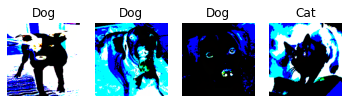

In [90]:
row, col = 1, 4
fig, axarr = plt.subplots(row, col)
axarr = axarr.flatten()

for i in range(row*col):
    axarr[i].set_title('Dog' if y[i] == 1 else 'Cat')
    axarr[i].imshow(x[i].numpy().transpose((1, 2, 0)).astype('uint8'))
    axarr[i].axis('off')

plt.show()

In [91]:
from collections import OrderedDict
device = 'cuda'

model = nn.Sequential(OrderedDict([
    ('lin1', nn.Linear(3*200*200, 256)),
    ('relu1', nn.ReLU()),
    ('lin2', nn.Linear(256, 256)),
    ('relu2', nn.ReLU()),
    ('lin3', nn.Linear(256, 128)),
    ('relu3', nn.ReLU()),
    ('lin4', nn.Linear(128, 32)),
    ('relu4', nn.ReLU()),
    ('lin5', nn.Linear(32, 2)),
    ('soft', nn.Softmax(dim = 1))
    ]))
    
model = model.to(device)

In [92]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [93]:
img = torch.rand(32, 3, 200, 200).to(device)
img = img.reshape(-1,3*200*200)
model(img).shape



torch.Size([32, 2])

In [94]:
def validation(model, testloader, criterion):
  test_loss = 0
  accuracy = 0 
  for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    images = images.reshape(-1,3*200*200)
    output = model.forward(images)
  
    test_loss += criterion(output, labels).item()

    ps = torch.exp(output)
    equality = ( labels.data == ps.max(dim=1)[1] )
    accuracy += equality.type(torch.FloatTensor).mean()
  return test_loss, accuracy

In [95]:
epochs = 3
steps = 0
running_loss = 0
print_every = 80
for e in range(epochs):
    for images, labels in train_dl:
        steps += 1
        images, labels = images.to(device), labels.to(device)
        images = images.reshape(-1,3*200*200)
        optimizer.zero_grad()
        output = model.forward(images)
       
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    

        if steps % print_every == 0:
          with torch.no_grad():
            test_loss, accuracy = validation(model, test_dl, criterion)
            
          print("Epoch: {}/{} ".format(e+1, epochs), \
                "Training Loss: {:.3f}.. ".format(running_loss/print_every), \
                "Test Loss: {:.3f}.. ".format(test_loss/len(test_dl)), \
                "Accuracy: {:.3f}.. ".format(accuracy/len(test_dl)) ) 
          running_loss = 0

Epoch: 1/3  Training Loss: 0.690..  Test Loss: 0.672..  Accuracy: 0.593.. 
Epoch: 1/3  Training Loss: 0.671..  Test Loss: 0.662..  Accuracy: 0.605.. 
Epoch: 1/3  Training Loss: 0.671..  Test Loss: 0.667..  Accuracy: 0.600.. 
Epoch: 1/3  Training Loss: 0.654..  Test Loss: 0.662..  Accuracy: 0.607.. 
Epoch: 1/3  Training Loss: 0.655..  Test Loss: 0.663..  Accuracy: 0.608.. 
Epoch: 1/3  Training Loss: 0.653..  Test Loss: 0.664..  Accuracy: 0.606.. 
Epoch: 1/3  Training Loss: 0.659..  Test Loss: 0.653..  Accuracy: 0.619.. 
Epoch: 2/3  Training Loss: 0.635..  Test Loss: 0.649..  Accuracy: 0.623.. 
Epoch: 2/3  Training Loss: 0.636..  Test Loss: 0.641..  Accuracy: 0.632.. 
Epoch: 2/3  Training Loss: 0.621..  Test Loss: 0.650..  Accuracy: 0.625.. 
Epoch: 2/3  Training Loss: 0.625..  Test Loss: 0.644..  Accuracy: 0.636.. 
Epoch: 2/3  Training Loss: 0.627..  Test Loss: 0.644..  Accuracy: 0.634.. 
Epoch: 2/3  Training Loss: 0.633..  Test Loss: 0.635..  Accuracy: 0.646.. 
Epoch: 2/3  Training Loss